# Description of a problem

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized.

The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import random
from pathlib import Path

import numpy as np
import pandas as pd

from hamiltonian_cycle.algorithms.lab1 import init_random_solution

# from hamiltonian_cycle.algorithms.lab3.objective_change import (
#     objective_change_inter_route,
#     objective_change_two_edges,
#     objective_change_two_nodes,
# )
# from hamiltonian_cycle.algorithms.lab3.operations import (
#     inter_route_swap,
#     two_edges_exchange,
#     two_nodes_exchange,
# )
from hamiltonian_cycle.costs import dm, function_cost

In [6]:
def read_dataset_csv(csv_path: Path) -> pd.DataFrame:
    return pd.read_csv(csv_path, sep=";", names=["x", "y", "cost"])


DATA_DIR = Path("../data").resolve()

ds_a = read_dataset_csv(DATA_DIR / "TSPA.csv")
ds_b = read_dataset_csv(DATA_DIR / "TSPB.csv")

dm_a = dm(ds_a)
dm_b = dm(ds_b)

In [7]:
best_solution = list(init_random_solution(ds_a, dm_a, 0).index)

In [9]:
best_solution = list(init_random_solution(ds_a, dm_a, 0).index)
ds_a.loc[best_solution]

,x,y,cost
97,2465,426,310
79,1852,682,561
13,3741,252,1839
20,34,1705,1371
95,3691,1650,1075
...,...,...,...
53,2097,299,81
116,883,826,345
59,1172,933,125
150,2540,260,1935


In [11]:
function_cost(ds_a.loc[list(init_random_solution(ds_a, dm_a, 0).index)])

277718

In [4]:
import numpy as np
import pandas as pd


def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    # Edges to be removed and added
    edges_removed = []
    edges_added = []

    # Remove edges connected to a and b
    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    # Calculate delta
    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta


def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    # Edges before and after reversal
    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta


def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    # Edge costs before and after the swap
    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    # Node costs before and after the swap
    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta


def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution


def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()  # No change if i >= j

    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution


def inter_route_swap(
    solution: list,
    i: int,
    vacant_node: int,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    # Update the node sets
    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes


def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes


def browse_intra_solutions(dm: np.ndarray, solution: list, intra_search: str) -> tuple:
    intra_neighbors = []
    n = len(solution)
    for i in range(n):
        for j in range(i + 1, n):
            if intra_search == "node":
                delta_nodes = objective_change_two_nodes(dm, solution, i, j)
                if delta_nodes < 0:
                    intra_neighbors.append((i, j, delta_nodes, "node"))
            elif intra_search == "edge":
                delta_edges = objective_change_two_edges(dm, solution, i, j)
                if delta_edges < 0:
                    intra_neighbors.append((i, j, delta_edges, "edge"))
    return intra_neighbors


def browse_inter_solutions(
    dm: np.ndarray, solution: list, non_selected_nodes: set, costs: list
) -> list:
    inter_neighbors = []
    for i in range(len(solution)):
        for vacant_node in non_selected_nodes:
            inter_delta = objective_change_inter_route(
                dm, solution, i, vacant_node, costs
            )
            if inter_delta < 0:
                inter_neighbors.append((i, vacant_node, inter_delta, "inter"))
    return inter_neighbors


def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes


def local_search(
    ds: pd.DataFrame,
    dm: np.ndarray,
    initial_solution: list,
    strategy: str = "greedy",
    intra_search: str = "edge",
    debug_mode: bool = True,
) -> pd.DataFrame:
    num_nodes = len(dm)
    initial_cost = function_cost(ds.loc[initial_solution])

    solution = initial_solution.copy()
    selected_nodes = set(initial_solution)
    non_selected_nodes = get_remaining_nodes(selected_nodes, num_nodes)

    while True:
        intra_neighbors = browse_intra_solutions(dm, solution, intra_search)
        inter_neighbors = browse_inter_solutions(
            dm, solution, non_selected_nodes, ds["cost"].tolist()
        )

        all_neighbors = intra_neighbors + inter_neighbors

        if not all_neighbors:
            # No improvement found
            break

        if strategy == "greedy":
            random.shuffle(all_neighbors)
            best_neighbor = next((n for n in all_neighbors if n[2] < 0), None)
        elif strategy == "steepest":
            best_neighbor = min(all_neighbors, key=lambda x: x[2])

        if best_neighbor is None:
            # No improving neighbor found
            break

        # Save the old solution for debugging
        old_solution = solution.copy()

        # Update solution and cost
        solution, selected_nodes, non_selected_nodes = update_solution(
            solution, best_neighbor, selected_nodes, non_selected_nodes
        )
        initial_cost += best_neighbor[2]

        if debug_mode:
            # Calculate real improvement
            real_improvement = function_cost(ds.loc[old_solution]) - function_cost(
                ds.loc[solution]
            )

            if real_improvement != -best_neighbor[2]:
                print(f"Promised improvement: {best_neighbor[2]}")
                print(f"Real improvement: {real_improvement}")
                print(f"Operation: {best_neighbor[-1]}")
                print("===========")

            assert function_cost(ds.loc[solution]) < function_cost(ds.loc[old_solution])

    return ds.loc[solution]


from hamiltonian_cycle.algorithms.lab1 import init_greedy_cycle
from hamiltonian_cycle.experiment import perform_experiment


def init_local_search(
    ds: pd.DataFrame,
    dm: np.ndarray,
    start: int,
    strategy: str,
    intra_search: str,
    debug_mode: bool = True,
    algo_to_enchance: str = "greedy_cycle",
) -> pd.DataFrame:
    if algo_to_enchance == "greedy_cycle":
        solution = list(init_greedy_cycle(ds, dm, start).index)
    elif algo_to_enchance == "random":
        solution = list(init_random_solution(ds, dm, start).index)
    solution = local_search(ds, dm, solution, strategy, intra_search, debug_mode)
    return solution

In [55]:
algos = ["greedy_cycle", "random"]
intra_search = ["node", "edge"]
strategy = ["greedy", "steepest"]

#### Results on Dataset A

Best solution: [198, 115, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 90, 27, 164, 39, 165, 185, 106, 178, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46]
Objective function statistics:
minimum = 70564
mean = 71409.285
maximum = 72444


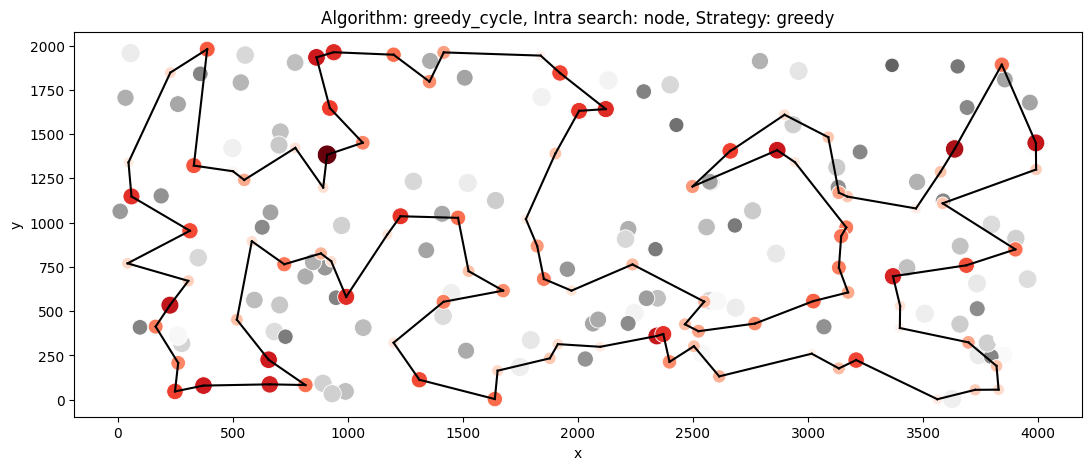

Best solution: [198, 115, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 90, 27, 164, 39, 165, 185, 106, 178, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46]
Objective function statistics:
minimum = 70564
mean = 71408.27
maximum = 72444


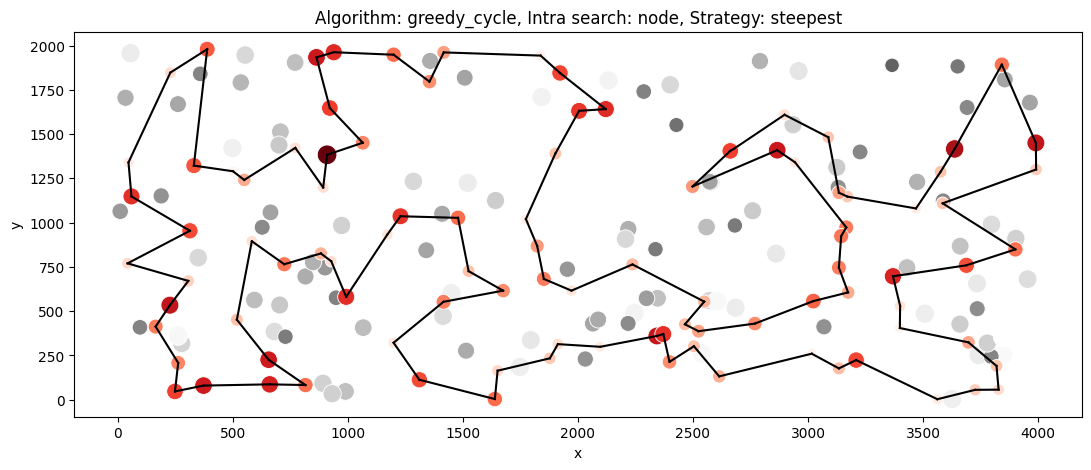

Best solution: [149, 65, 116, 43, 42, 115, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 90, 27, 39, 165, 185, 106, 178, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 131]
Objective function statistics:
minimum = 70334
mean = 71276.885
maximum = 72378


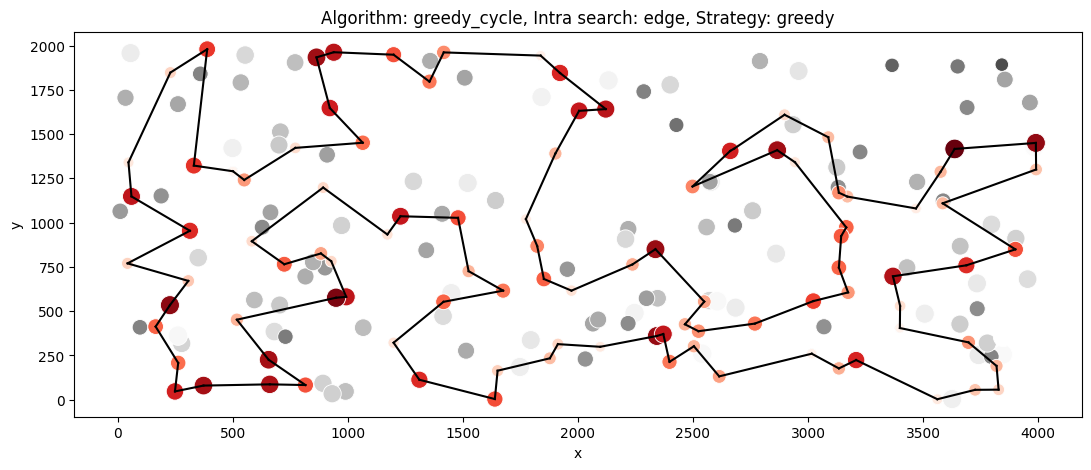

Best solution: [162, 133, 151, 51, 118, 59, 149, 131, 65, 116, 43, 42, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 146, 22, 18, 108, 159, 193, 41, 139, 115, 46, 68, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 152, 97, 1, 2, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 178, 106, 185, 165, 39, 27, 90, 40, 81, 196, 179, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 75, 101, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123]
Objective function statistics:
minimum = 70174
mean = 71259.05
maximum = 72378


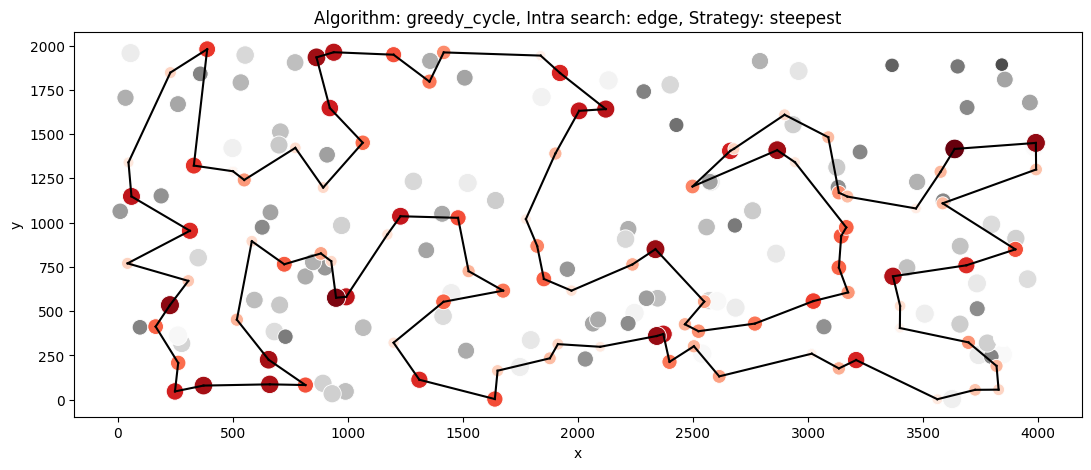

Best solution: [55, 57, 179, 81, 90, 165, 40, 185, 196, 113, 175, 171, 16, 31, 120, 75, 86, 53, 180, 154, 162, 149, 131, 112, 84, 184, 160, 195, 159, 22, 146, 34, 54, 10, 177, 48, 18, 108, 93, 117, 143, 0, 68, 46, 109, 51, 137, 23, 183, 89, 186, 15, 62, 9, 148, 124, 94, 152, 1, 101, 97, 26, 63, 79, 133, 151, 80, 167, 49, 14, 144, 102, 176, 118, 59, 116, 115, 139, 41, 193, 181, 42, 43, 65, 123, 127, 70, 135, 2, 129, 145, 78, 25, 44, 82, 92, 178, 3, 106, 52]
Objective function statistics:
minimum = 79361
mean = 86019.175
maximum = 94279


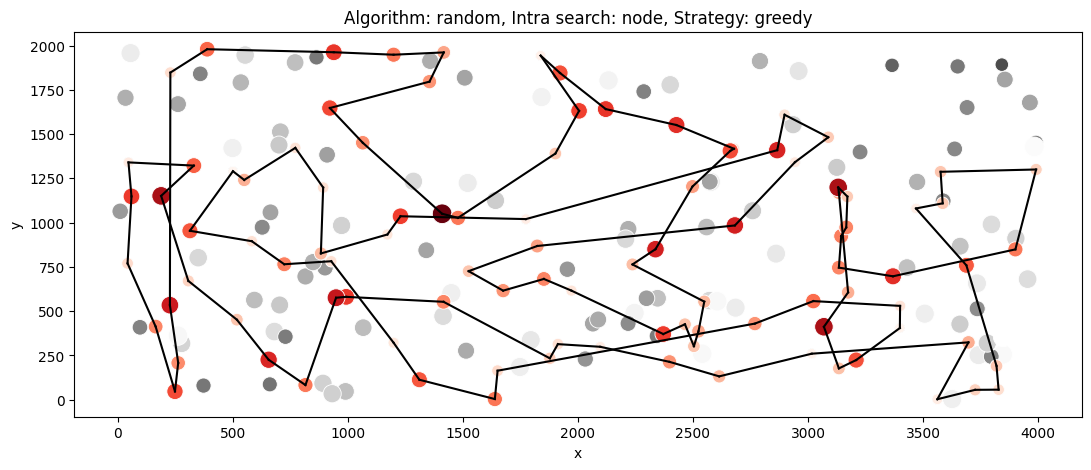

Best solution: [23, 89, 183, 143, 0, 117, 108, 18, 22, 159, 193, 41, 5, 42, 181, 34, 177, 10, 190, 162, 133, 80, 176, 151, 112, 4, 84, 35, 43, 139, 68, 46, 115, 116, 47, 65, 59, 118, 51, 79, 63, 180, 53, 100, 26, 97, 94, 137, 148, 124, 152, 120, 44, 25, 78, 145, 92, 179, 185, 165, 27, 90, 113, 175, 171, 16, 31, 196, 40, 119, 57, 129, 2, 75, 86, 154, 135, 123, 149, 160, 48, 54, 184, 70, 101, 1, 167, 49, 55, 52, 106, 178, 3, 138, 14, 144, 102, 62, 9, 186]
Objective function statistics:
minimum = 80496
mean = 88282.39
maximum = 97239


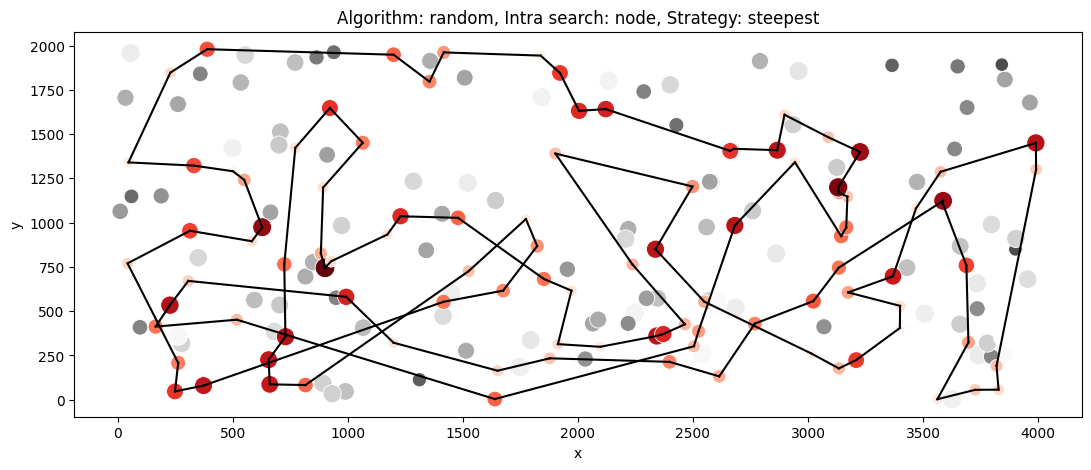

Best solution: [129, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 154, 180, 63, 79, 133, 135, 70, 127, 112, 4, 84, 190, 10, 177, 54, 48, 184, 160, 34, 181, 42, 5, 43, 116, 65, 47, 131, 149, 123, 162, 151, 51, 118, 59, 115, 41, 193, 159, 146, 22, 18, 108, 69, 139, 198, 46, 68, 117, 0, 143, 183, 89, 23, 137, 176, 80, 94, 124, 148, 9, 62, 102, 49, 144, 14, 178, 106, 52, 55, 57, 179, 185, 40, 119, 165, 27, 90, 81, 196, 113, 175, 171, 16, 31, 145, 78, 44, 120, 92]
Objective function statistics:
minimum = 71536
mean = 73930.555
maximum = 76814


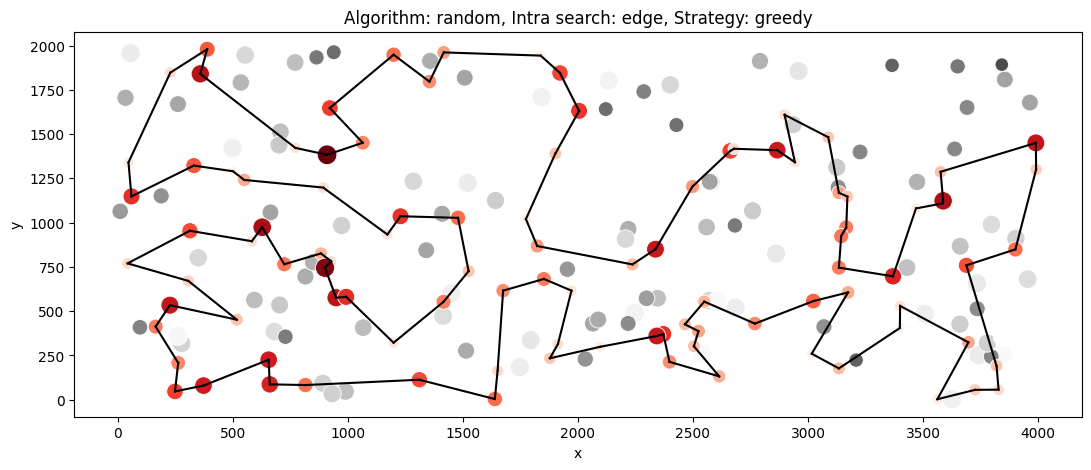

Best solution: [148, 9, 62, 144, 102, 49, 14, 3, 178, 106, 185, 40, 119, 165, 39, 27, 90, 81, 196, 157, 31, 56, 113, 175, 171, 16, 78, 145, 179, 52, 55, 57, 92, 129, 25, 44, 120, 2, 75, 101, 86, 100, 26, 97, 1, 152, 189, 121, 53, 180, 154, 135, 127, 112, 4, 190, 10, 177, 54, 34, 160, 184, 149, 123, 162, 151, 59, 118, 46, 139, 115, 116, 65, 43, 42, 181, 41, 193, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89, 23, 137, 51, 176, 80, 133, 79, 122, 63, 94, 124]
Objective function statistics:
minimum = 72046
mean = 74033.715
maximum = 78801


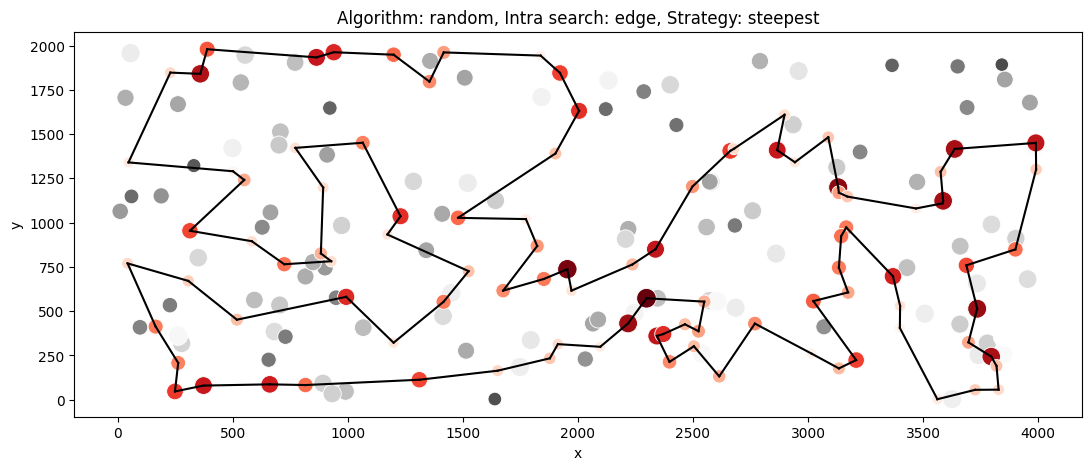

In [56]:
for algo in algos:
    for search in intra_search:
        for strat in strategy:
            perform_experiment(
                ds_a,
                dm_a,
                f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat}",
                init_local_search,
                **{
                    "strategy": strat,
                    "intra_search": search,
                    "debug_mode": True,
                    "algo_to_enchance": algo,
                },
            )

#### Results on Dataset B

Best solution: [4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 78, 175, 142, 5, 177, 21, 82, 111, 8, 104, 138, 11, 139, 182, 25, 136, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Objective function statistics:
minimum = 45193
mean = 46549.125
maximum = 47677


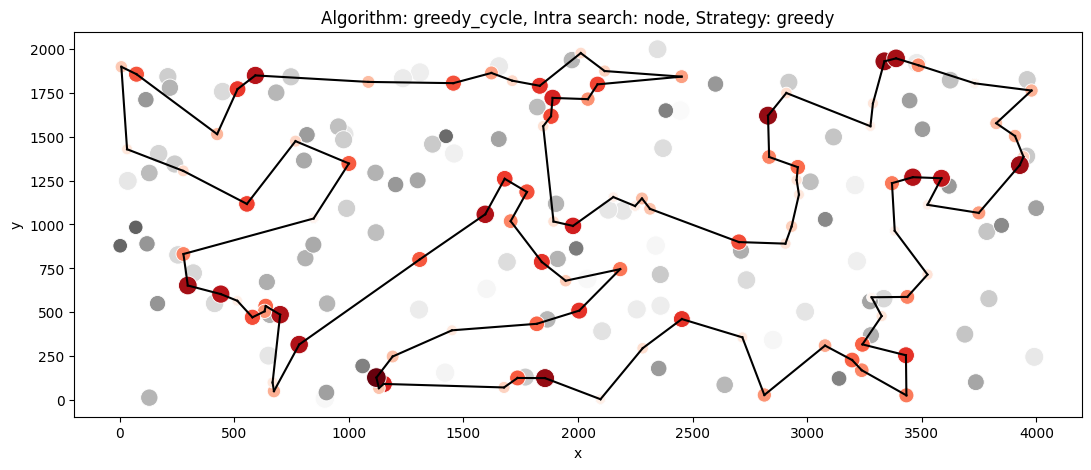

Best solution: [4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 78, 175, 142, 5, 177, 21, 82, 111, 8, 104, 138, 11, 139, 182, 25, 136, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Objective function statistics:
minimum = 45193
mean = 46537.475
maximum = 47682


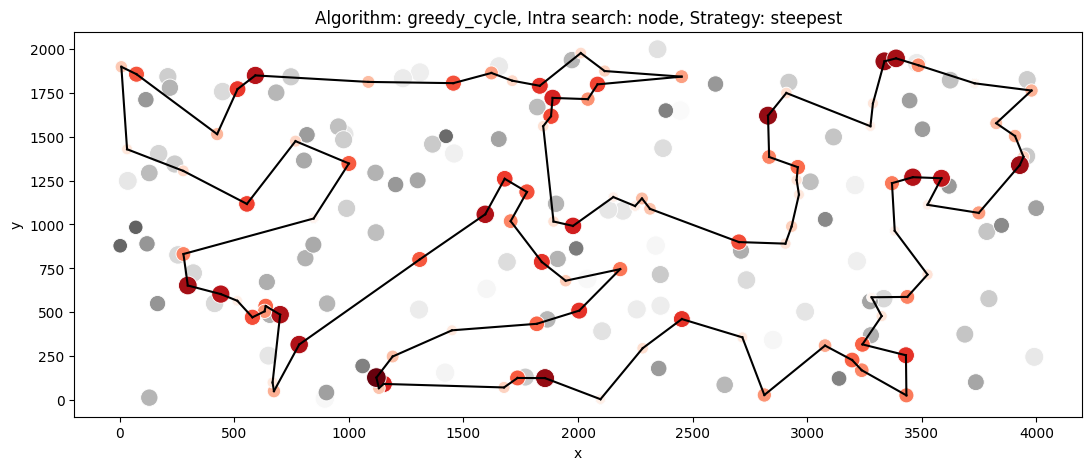

Best solution: [60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 177, 21, 82, 111, 8, 104, 25, 5, 78, 175, 142, 45, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 139, 11, 182, 138, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 4, 149, 28, 20]
Objective function statistics:
minimum = 44675
mean = 45788.065
maximum = 47432


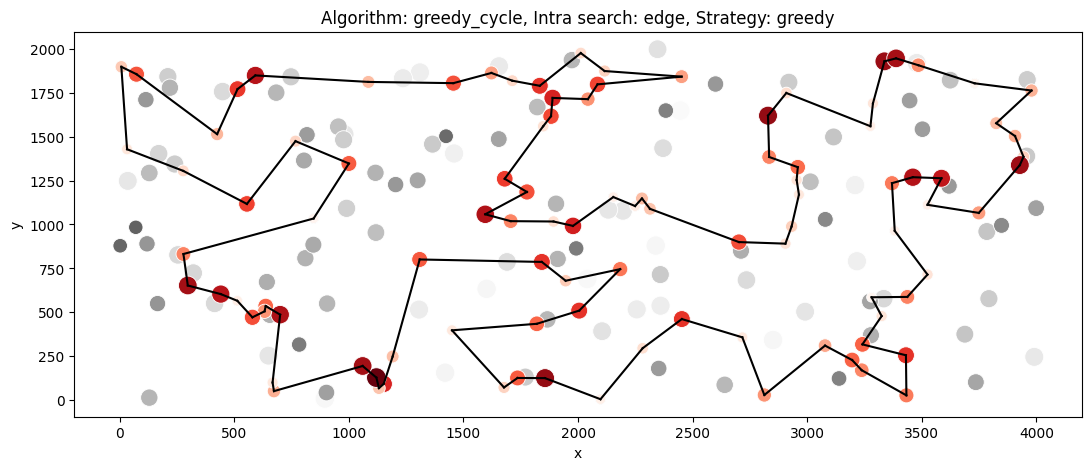

Best solution: [4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 5, 78, 175, 45, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 139, 11, 138, 182, 25, 177, 21, 82, 111, 8, 104, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Objective function statistics:
minimum = 44472
mean = 45564.175
maximum = 47045


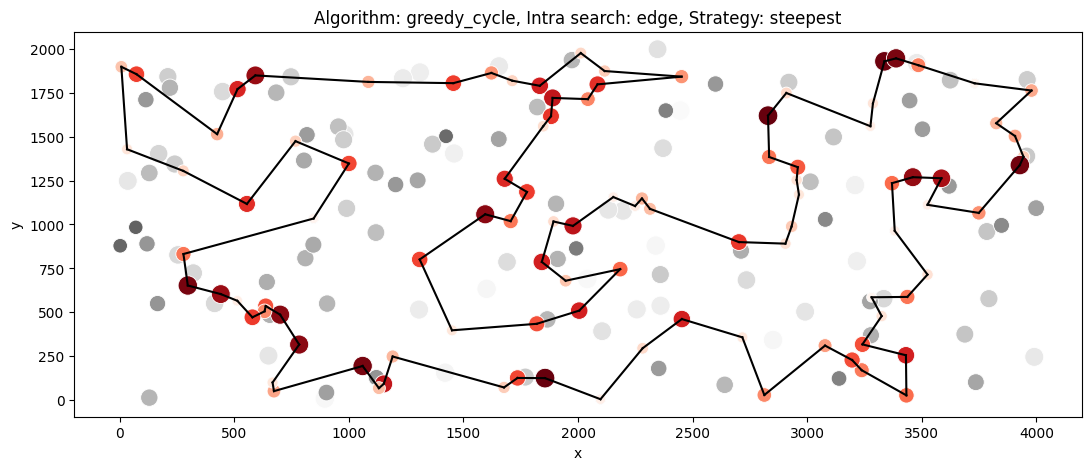

Best solution: [3, 15, 145, 29, 81, 153, 163, 89, 103, 113, 180, 176, 166, 179, 66, 94, 47, 148, 60, 20, 28, 149, 140, 183, 55, 143, 111, 82, 61, 36, 91, 141, 77, 187, 165, 127, 114, 194, 86, 185, 95, 152, 155, 6, 147, 191, 90, 131, 121, 118, 74, 182, 138, 139, 51, 122, 63, 135, 1, 117, 193, 31, 54, 73, 21, 87, 8, 56, 33, 160, 0, 35, 109, 168, 195, 13, 70, 161, 132, 169, 188, 134, 25, 78, 175, 142, 45, 80, 190, 136, 5, 177, 104, 144, 159, 106, 124, 62, 18, 34]
Objective function statistics:
minimum = 54745
mean = 60805.595
maximum = 67472


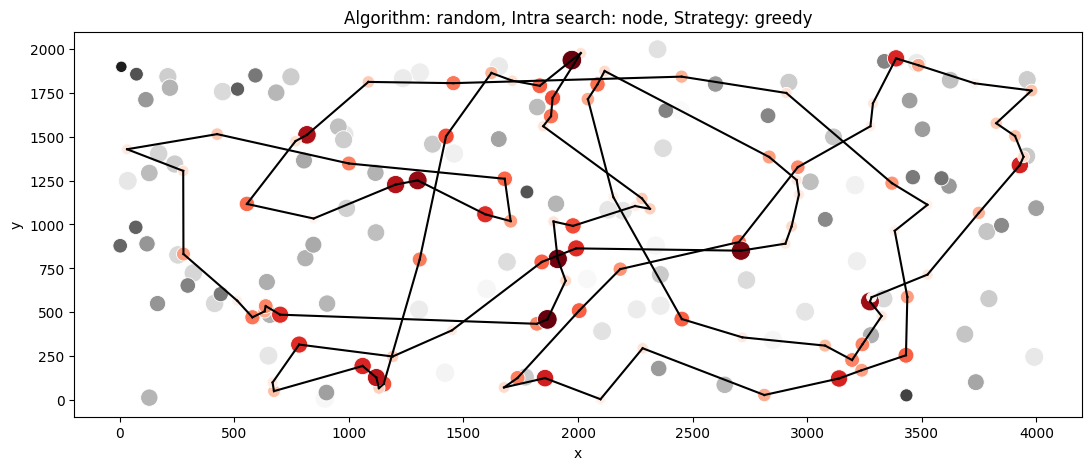

Best solution: [3, 155, 34, 55, 18, 62, 11, 139, 182, 138, 33, 160, 144, 104, 8, 82, 21, 25, 121, 125, 90, 131, 1, 117, 54, 31, 193, 190, 80, 45, 61, 91, 77, 81, 106, 124, 176, 180, 88, 194, 86, 95, 130, 148, 60, 20, 28, 149, 140, 183, 152, 170, 109, 29, 0, 35, 153, 165, 89, 127, 137, 187, 141, 36, 175, 78, 5, 177, 111, 143, 128, 185, 179, 47, 94, 66, 57, 172, 166, 113, 103, 163, 145, 195, 168, 132, 169, 188, 6, 134, 51, 191, 122, 135, 63, 40, 107, 133, 147, 70]
Objective function statistics:
minimum = 55783
mean = 62911.32
maximum = 71844


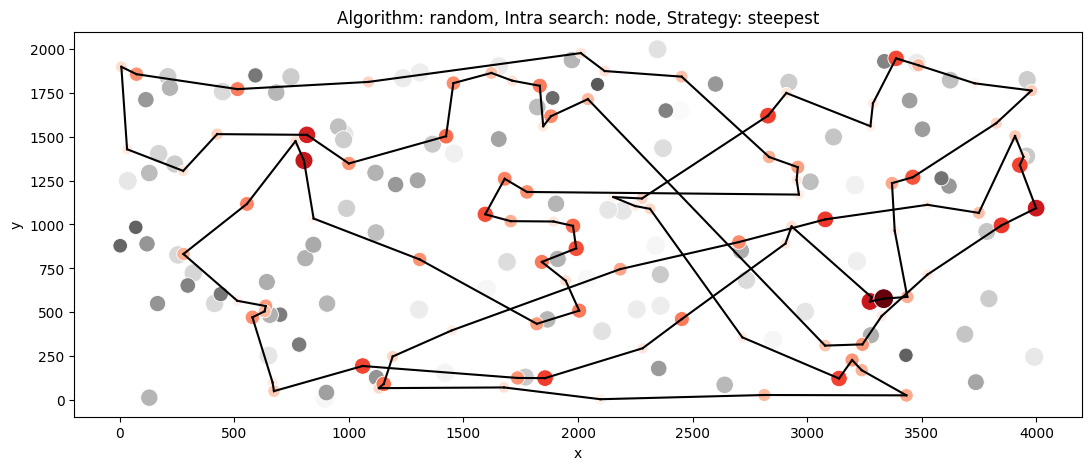

Best solution: [141, 82, 8, 77, 153, 187, 165, 127, 89, 163, 103, 113, 176, 194, 166, 86, 95, 130, 185, 179, 94, 47, 148, 60, 20, 59, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 128, 124, 106, 143, 35, 109, 0, 29, 160, 33, 138, 11, 139, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 134, 118, 98, 51, 191, 90, 125, 121, 131, 135, 122, 133, 107, 40, 63, 38, 27, 16, 1, 156, 42, 30, 198, 117, 193, 54, 31, 164, 73, 136, 190, 80, 175, 78, 5, 177, 21, 61, 36]
Objective function statistics:
minimum = 45876
mean = 48453.8
maximum = 51449


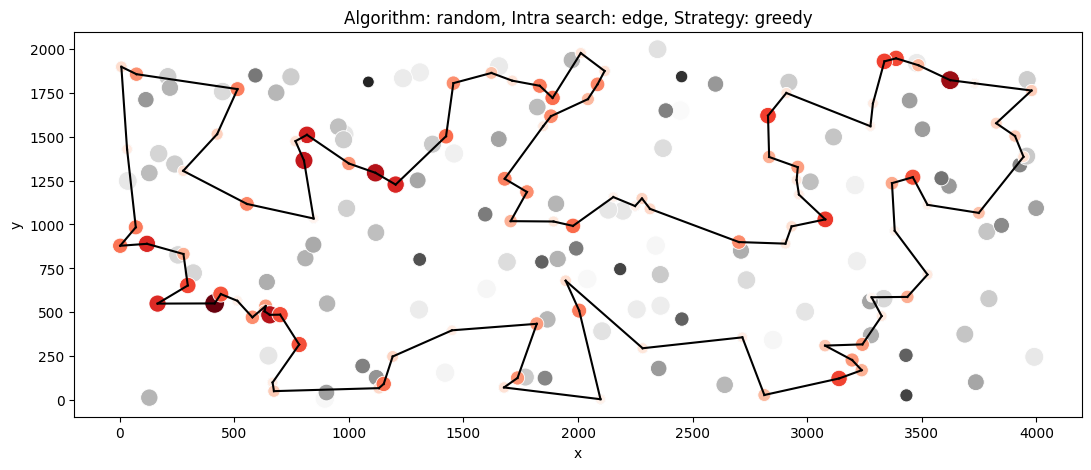

Best solution: [159, 106, 124, 62, 18, 55, 34, 152, 149, 28, 20, 60, 47, 94, 66, 148, 199, 140, 183, 95, 130, 99, 179, 185, 86, 166, 194, 176, 180, 113, 114, 137, 127, 165, 89, 103, 26, 163, 187, 153, 77, 111, 144, 56, 104, 8, 82, 21, 141, 61, 36, 177, 5, 45, 142, 78, 175, 162, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 121, 131, 135, 63, 40, 107, 133, 122, 90, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 139, 11, 138, 33, 160, 29, 0, 109, 35, 143]
Objective function statistics:
minimum = 45393
mean = 48264.78
maximum = 50697


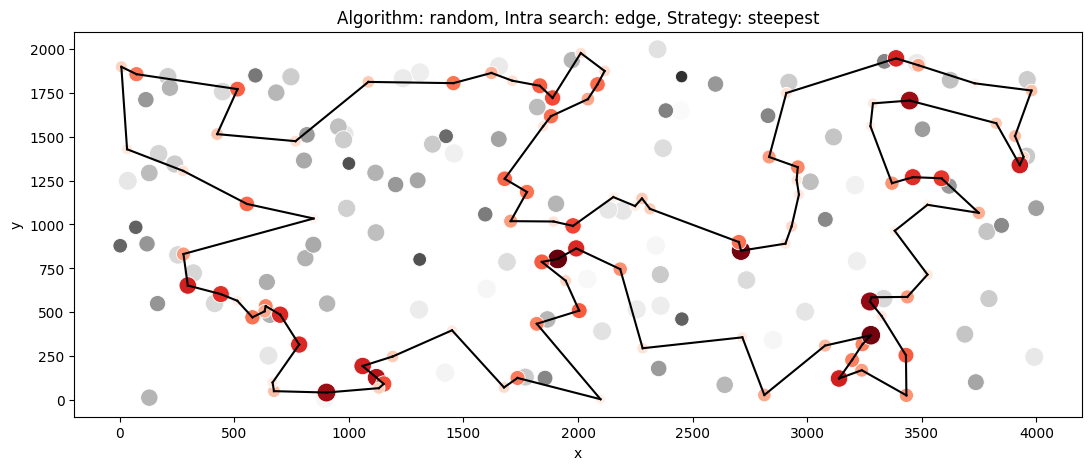

In [57]:
for algo in algos:
    for search in intra_search:
        for strat in strategy:
            perform_experiment(
                ds_b,
                dm_b,
                f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat}",
                init_local_search,
                **{
                    "strategy": strat,
                    "intra_search": search,
                    "debug_mode": True,
                    "algo_to_enchance": algo,
                },
            )

# Summary

In [16]:
a_res = pd.DataFrame(
    {
        "greedy_cycle": [71263, 72071.915, 73154],
        "greedy_cycle_node_greedy": [70564, 71409.285, 72444],
        "greedy_cycle_node_steepest": [70564, 71408.27, 72444],
        "greedy_cycle_edge_greedy": [70334, 71276.885, 72378],
        "greedy_cycle_edge_steepest": [70174, 71259.05, 72378],
        "random_node_greedy": [79361, 86019.175, 94279],
        "random_node_steepest": [80496, 88282.39, 97239],
        "random_cycle_edge_greedy": [71536, 73930.555, 76814],
        "random_cycle_edge_steepest": [72046, 74033.715, 78801],
    },
    index=pd.MultiIndex.from_tuples(
        [("Dataset A", "min"), ("Dataset A", "mean"), ("Dataset A", "max")]
    ),
).T

b_res = pd.DataFrame(
    {
        "greedy_cycle": [45312, 46903.73, 48623],
        "greedy_cycle_node_greedy": [45193, 46549.125, 47677],
        "greedy_cycle_node_steepest": [45193, 46537.475, 47682],
        "greedy_cycle_edge_greedy": [44675, 45788.065, 47432],
        "greedy_cycle_edge_steepest": [44472, 45564.175, 47045],
        "random_node_greedy": [54745, 60805.595, 67472],
        "random_node_steepest": [55783, 62911.32, 71844],
        "random_cycle_edge_greedy": [45876, 48453.8, 51449],
        "random_cycle_edge_steepest": [45393, 48264.78, 50697],
    },
    index=pd.MultiIndex.from_tuples(
        [("Dataset B", "min"), ("Dataset B", "mean"), ("Dataset B", "max")]
    ),
).T

a_res.join(b_res).sort_values(by=("Dataset A", "mean"))

Dataset A                     Dataset B             \
                                 min       mean      max       min       mean   
greedy_cycle_edge_steepest   70174.0  71259.050  72378.0   44472.0  45564.175   
greedy_cycle_edge_greedy     70334.0  71276.885  72378.0   44675.0  45788.065   
greedy_cycle_node_steepest   70564.0  71408.270  72444.0   45193.0  46537.475   
greedy_cycle_node_greedy     70564.0  71409.285  72444.0   45193.0  46549.125   
greedy_cycle                 71263.0  72071.915  73154.0   45312.0  46903.730   
random_cycle_edge_greedy     71536.0  73930.555  76814.0   45876.0  48453.800   
random_cycle_edge_steepest   72046.0  74033.715  78801.0   45393.0  48264.780   
random_node_greedy           79361.0  86019.175  94279.0   54745.0  60805.595   
random_node_steepest         80496.0  88282.390  97239.0   55783.0  62911.320   

                                     
                                max  
greedy_cycle_edge_steepest  47045.0  
greedy_cycle_edge_greedy    47432.0  
greedy_cycle_node_steepest  47682.0  
greedy_cycle_node_greedy    47677.0  
greedy_cycle                48623.0  
random_cycle_edge_greedy    51449.0  
random_cycle_edge_steepest  50697.0  
random_node_greedy          67472.0  
random_node_steepest        71844.0